# **Notebook 1**: Data Visualisation

In [44]:
INSTALL_PACKAGES = False

In [45]:
libraries = {
    "pillow": "PIL",
    "folium": "folium",
    "matplotlib": "matplotlib",
}

COLORS = {
    "green": "\033[92m",
    "red": "\033[91m",
    "end": "\033[0m"
}

if INSTALL_PACKAGES:
    for package, module in libraries.items():
        %pip install {module}
        print(f"{COLORS['green']}[+] Installing {package}{COLORS['end']}")

In [46]:
group_5_members = ["AlisonAttard", "BenTaliana", "MichaelFarrugia", "MelatAssefa"]

In [47]:
import os

all_images_paths = [os.path.join(member, "images", img) for member in group_5_members for img in os.listdir(os.path.join(member, "images"))]
all_images_json_path = os.path.join("dataset", "merged_input.json")

## **Dataset Annotation Statistics and Checks**

In [48]:
num_images_per_member = {member: len([img for img in all_images_paths if img.startswith(os.path.join(member, "images"))]) for member in group_5_members}
total_images = len([img for img in all_images_paths])

In [49]:
from json import loads

with open(all_images_json_path, "r") as f:
    all_images_json = loads(f.read())

    assert len(all_images_json) == total_images, f"Missing annotations in merged JSON: expected {total_images}, found {len(all_images_json)}"

optionally eventually we can do the statistics per member but i think that might be pointless

In [50]:
from collections import defaultdict, Counter

sign_type_statistics = defaultdict(Counter)
viewing_angle_statistics = defaultdict(Counter)
mounting_type_statistics = defaultdict(Counter)
sign_condition_statistics = defaultdict(Counter)
sign_shape_statistics = defaultdict(Counter)

Most signs have an expected sign shape. For our dataset, we expect:
- "Stop" signs to be octagonal
- "No Entry (One Way)" signs to be circular
- "Pedestrian Crossing (Zebra Crossing)" signs to be square
- "Roundabout Ahead" signs to be triangular
- "No Through Road (T-Sign)" signs to be square
- "Blind-Spot Mirrors (Convex Mirrors)" signs to be circular

In [51]:
def expect_sign_shape(sign_type: str, sign_shape: str, img_filename: str):
    expected_shapes = {
        "Stop": "Octagonal",
        "No Entry (One Way)": "Circular",
        "Pedestrian Crossing": "Square",
        "Roundabout Ahead": "Triangular",
        "No Through Road (T-Sign)": "Square",
        "Blind-Spot Mirror (Convex)": "Circular"
    }

    if sign_shape == "Damaged":
        return

    if expected_shapes [sign_type] != sign_shape:
        print(f"{COLORS ['red']}[!] Sign shape mismatch for '{img_filename}': expected '{expected_shapes [sign_type]} ({sign_type})', found '{sign_shape}'{COLORS['end']}. Double check to make sure this annotation is accurate")

In [52]:
# the annotated attribute type for viewing angle should match what is seen on the filename
for json_entry in all_images_json:
    filename = json_entry ["file_upload"].split("-") [1]

    annotated_items = [
        item
        for annotation in json_entry ["annotations"]
        for item in annotation ["result"]
    ]

    annotated_view_angle = list(filter(lambda item: item.get("from_name") == "view_angle", annotated_items)) [0] ["value"] ["choices"] [0]

    filename_view_angle = filename.replace(".jpeg", ".jpg").split(".jpg") [0].split("_")[-1]

    if annotated_view_angle != filename_view_angle:
        print(f"{COLORS ['red']}[!] View angle mismatch for '{filename}': expected '{filename_view_angle}', found '{annotated_view_angle}'{COLORS['end']}. Double check to make sure this annotation is accurate")

    member_name = filename.split("_") [0]

    viewing_angle_statistics [member_name] [annotated_view_angle] += 1
    
    if annotated_view_angle != "Front":
        continue

    annotated_sign_type = list(filter(lambda item: item.get("from_name") == "sign_type", annotated_items)) [0] ["value"] ["rectanglelabels"] [0]

    annotated_mounting_type = list(filter(lambda item: item.get("from_name") == "mounting", annotated_items)) [0] ["value"] ["choices"] [0]

    annotated_sign_condition = list(filter(lambda item: item.get("from_name") == "condition", annotated_items)) [0] ["value"] ["choices"] [0]

    annotated_sign_shape = list(filter(lambda item: item.get("from_name") == "sign_shape", annotated_items)) [0] ["value"] ["choices"] [0]
    
    expect_sign_shape(annotated_sign_type, annotated_sign_shape, filename)

    sign_type_statistics [member_name] [annotated_sign_type] += 1
    mounting_type_statistics [member_name] [annotated_mounting_type] += 1
    sign_condition_statistics [member_name] [annotated_sign_condition] += 1
    sign_shape_statistics [member_name] [annotated_sign_shape] += 1

[!] Sign shape mismatch for 'AlisonAttard_4_Front.jpeg': expected 'Octagonal (Stop)', found 'Circular'. Double check to make sure this annotation is accurate
[!] Sign shape mismatch for 'AlisonAttard_6_Front.jpeg': expected 'Octagonal (Stop)', found 'Circular'. Double check to make sure this annotation is accurate
[!] View angle mismatch for 'AlisonAttard_14_Back.jpeg': expected 'Back', found 'Front'. Double check to make sure this annotation is accurate
[!] Sign shape mismatch for 'AlisonAttard_17_Front.jpeg': expected 'Square (Pedestrian Crossing)', found 'Triangular'. Double check to make sure this annotation is accurate
[!] View angle mismatch for 'AlisonAttard_24_Back.jpeg': expected 'Back', found 'Front'. Double check to make sure this annotation is accurate
[!] View angle mismatch for 'AlisonAttard_34_Back.jpeg': expected 'Back', found 'Front'. Double check to make sure this annotation is accurate
[!] View angle mismatch for 'AlisonAttard_37_Front.jpeg': expected 'Front', found 

### Bar Charts for Dataset Statistics

In [53]:
import matplotlib.colors as mcolors
import colorsys

def adjust_lightness(hex_colour, amount = 0.5):
    try:
        c = mcolors.to_rgb(hex_colour)
        h, l, s = colorsys.rgb_to_hls(*c)
        l = max(0, min(1, l * amount))
        
        return mcolors.to_hex(colorsys.hls_to_rgb(h, l, s))
    except:
        return hex_colour

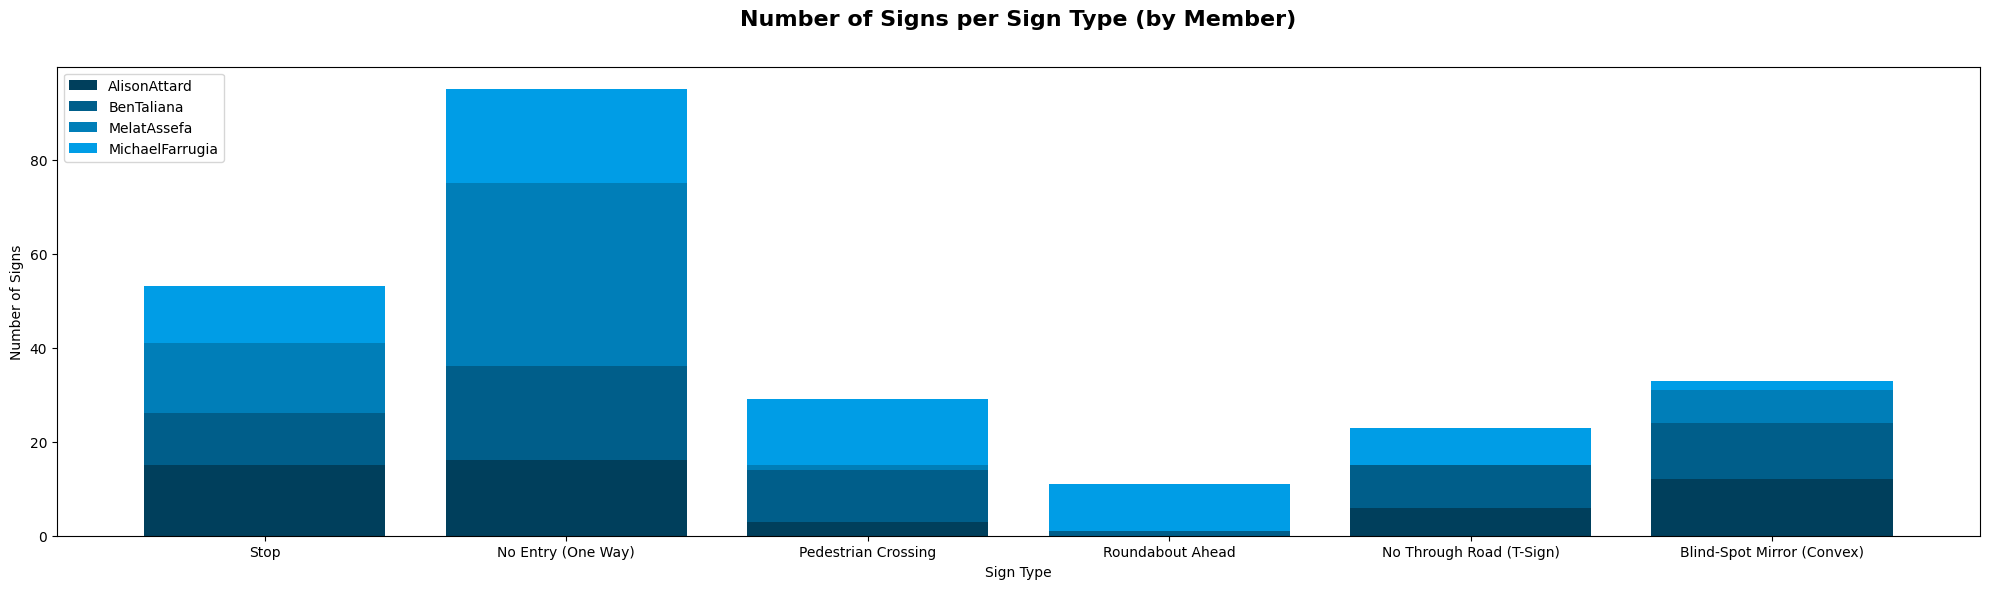

In [54]:
import matplotlib.pyplot as plt
import numpy as np

sign_types = ["Stop", "No Entry (One Way)", "Pedestrian Crossing", "Roundabout Ahead", "No Through Road (T-Sign)", "Blind-Spot Mirror (Convex)"]

plt.figure(figsize = (20, 6))
bottom = np.zeros(len(sign_types))

for i, person in enumerate(viewing_angle_statistics.keys()):
    counts = [sign_type_statistics [person] [sign_type] for sign_type in sign_types]

    step_darkness = 1.0 + (i * 0.5)
    current_colour = adjust_lightness("#003f5c", step_darkness)

    plt.bar(sign_types, counts, bottom = bottom, label = person, color = current_colour)

    bottom = np.add(bottom, counts)

plt.xlabel("Sign Type")
plt.ylabel("Number of Signs")
plt.title("Number of Signs per Sign Type (by Member)", fontsize = 16, fontweight = "bold", pad = 30)
plt.legend(loc = "upper left")
plt.tight_layout()
plt.show()

**note from mike here**: in some of my images, when the signs were right against each other, and i couldnt capture the back side of a sign, i didnt take the "back angle". for example, when a stop sign was attached against a no entry sign, i only took the front of the stop sign, and the side angle of the no entry sign

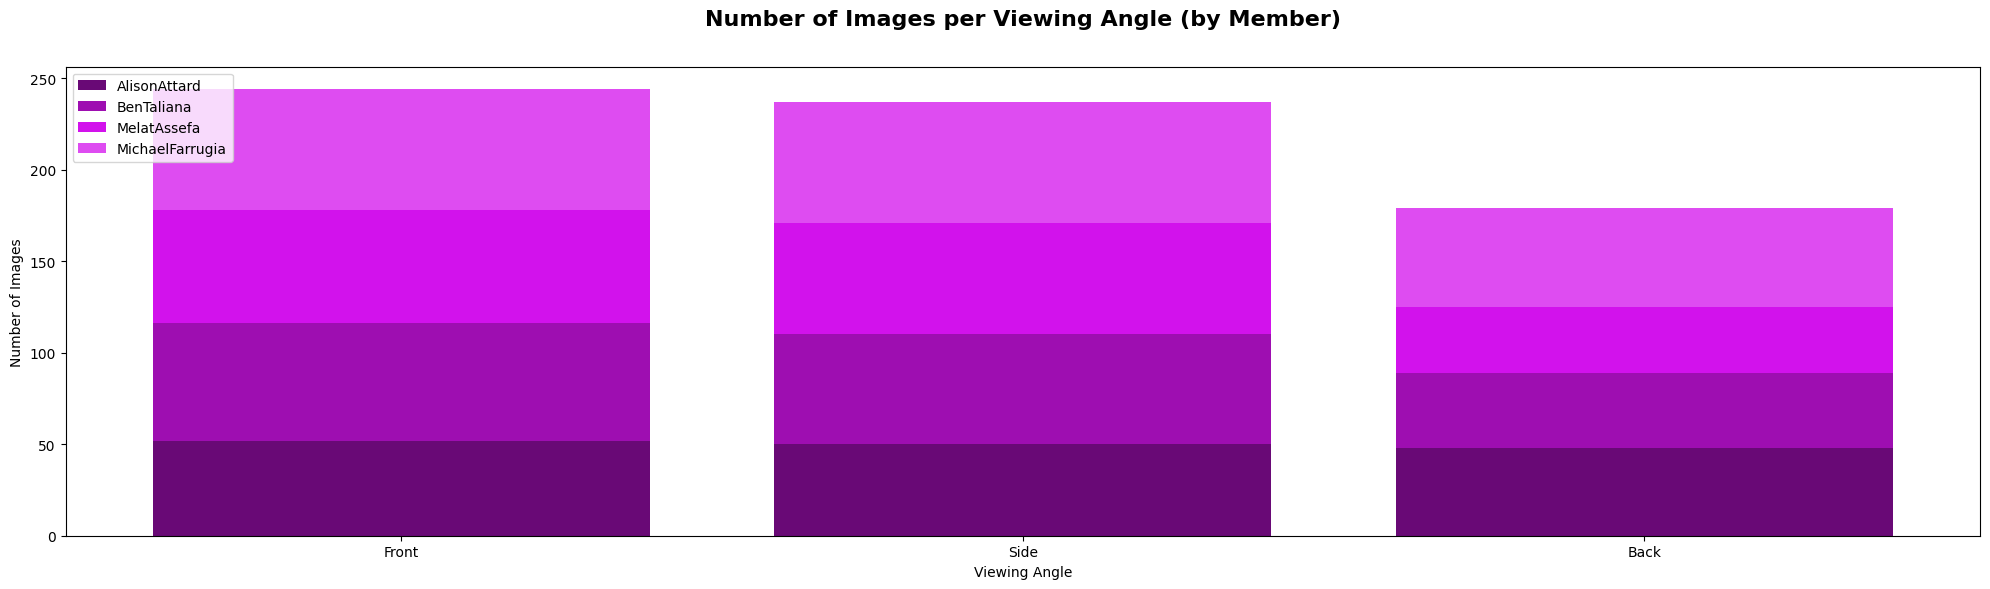

In [55]:
views = ["Front", "Side", "Back"]

plt.figure(figsize=(20, 6))
bottom = np.zeros(len(views))

for i, person in enumerate(viewing_angle_statistics.keys()):
    counts = [viewing_angle_statistics [person] [view] for view in views]
    
    step_darkness = 1.0 + (i * 0.5) 
    current_colour = adjust_lightness("#690976", step_darkness)

    plt.bar(views, counts, bottom = bottom, label = person, color = current_colour)
    
    bottom = np.add(bottom, counts)

plt.xlabel("Viewing Angle")
plt.ylabel("Number of Images")
plt.title("Number of Images per Viewing Angle (by Member)", fontsize=16, fontweight="bold", pad=30)
plt.legend(loc = "upper left")
plt.tight_layout()
plt.show()

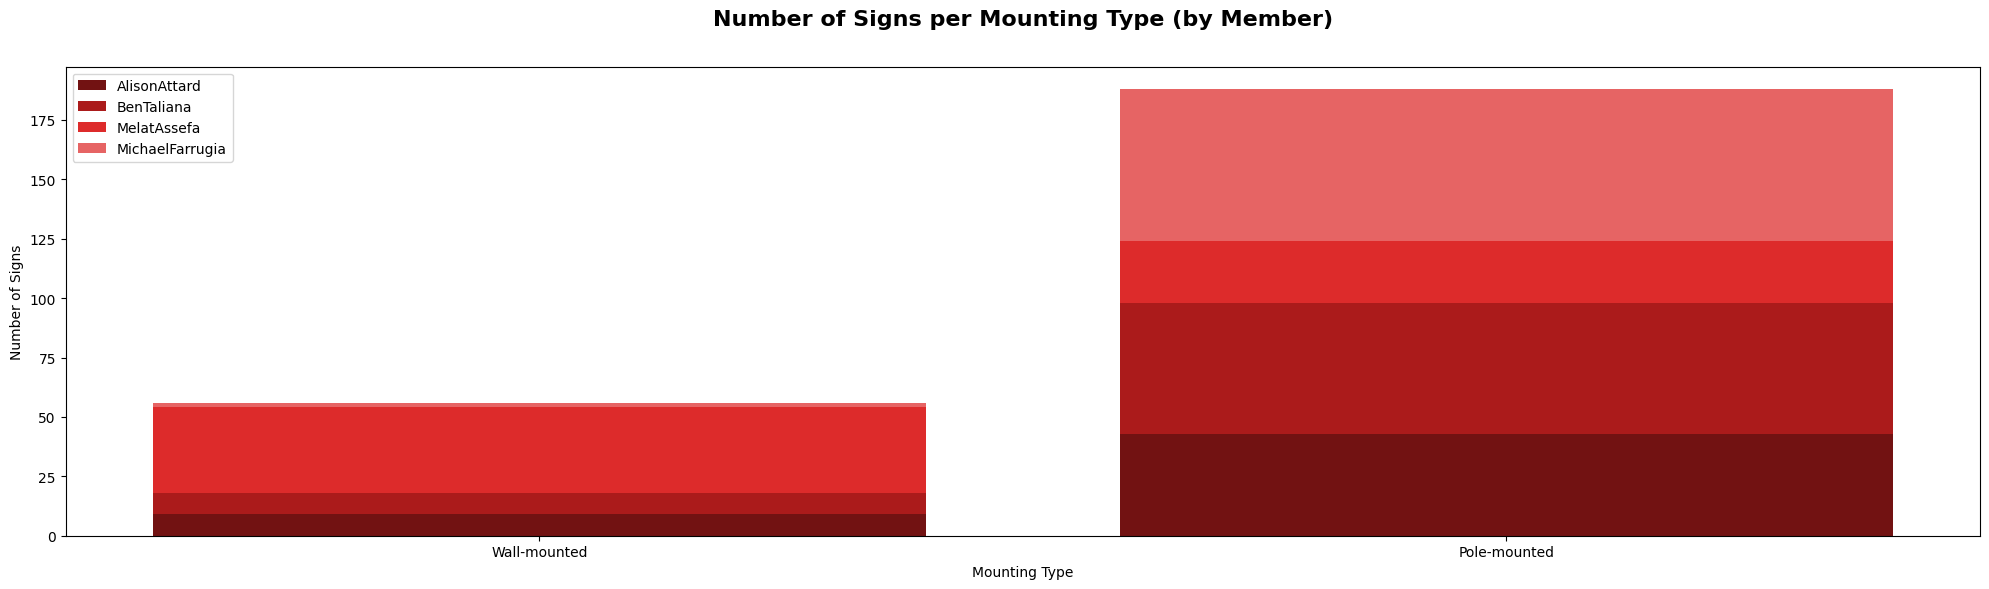

In [56]:
mounting_types = ["Wall-mounted", "Pole-mounted"]

plt.figure(figsize = (20, 6))
bottom = np.zeros(len(mounting_types))

for i, person in enumerate(viewing_angle_statistics.keys()):
    counts = [mounting_type_statistics [person] [mounting_type] for mounting_type in mounting_types]

    step_darkness = 1.0 + (i * 0.5)
    current_colour = adjust_lightness("#721212", step_darkness)

    plt.bar(mounting_types, counts, bottom = bottom, label = person, color = current_colour)

    bottom = np.add(bottom, counts)

plt.xlabel("Mounting Type")
plt.ylabel("Number of Signs")
plt.title("Number of Signs per Mounting Type (by Member)", fontsize = 16, fontweight = "bold", pad = 30)
plt.legend(loc = "upper left")
plt.tight_layout()
plt.show()

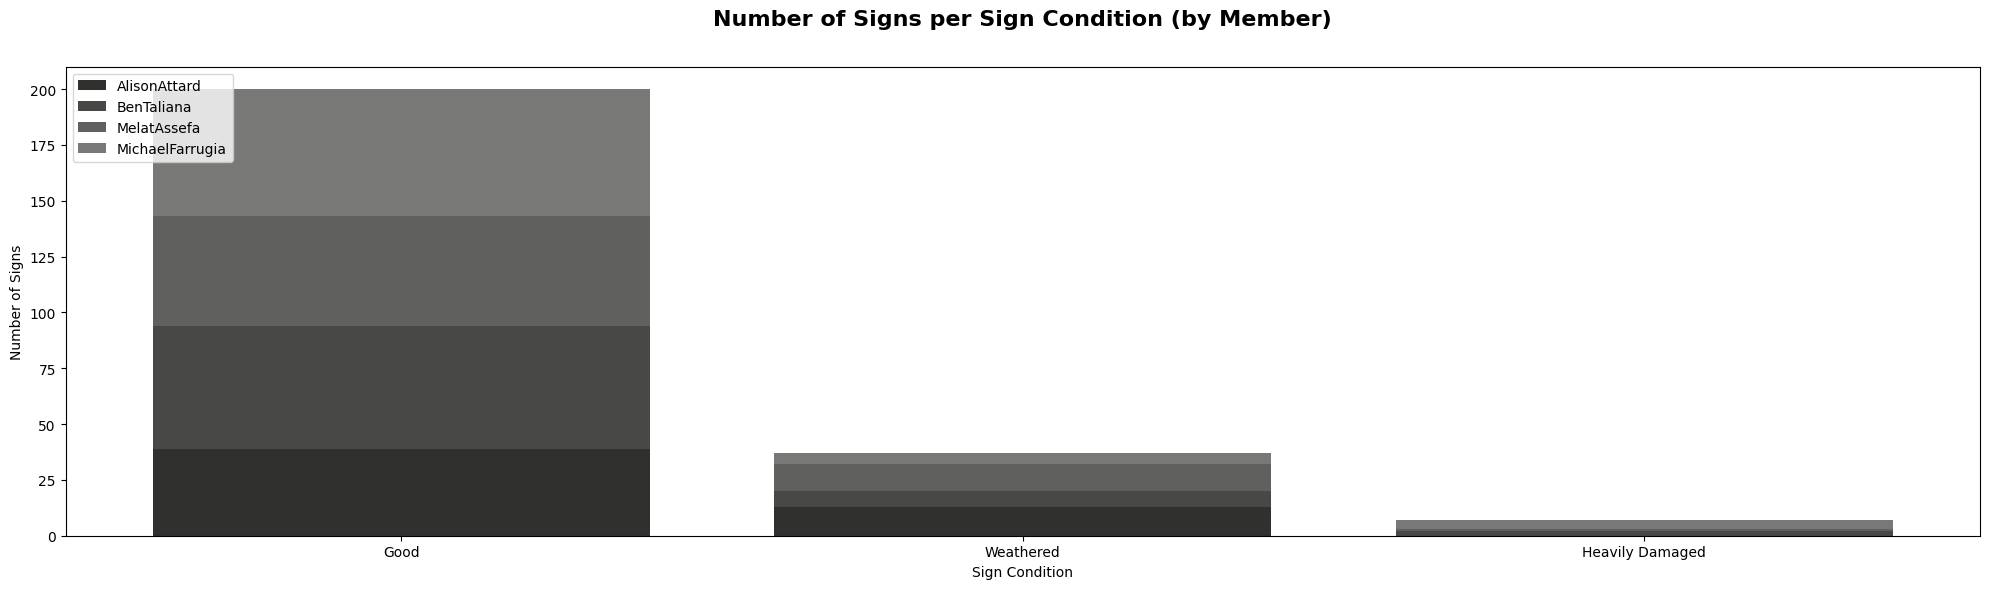

In [57]:
sign_conditions = ["Good", "Weathered", "Heavily Damaged"]

plt.figure(figsize = (20, 6))
bottom = np.zeros(len(sign_conditions))

for i, person in enumerate(viewing_angle_statistics.keys()):
    counts = [sign_condition_statistics [person] [sign_condition] for sign_condition in sign_conditions]

    step_darkness = 1.0 + (i * 0.5)
    current_colour = adjust_lightness("#30302F", step_darkness)

    plt.bar(sign_conditions, counts, bottom = bottom, label = person, color = current_colour)

    bottom = np.add(bottom, counts)

plt.xlabel("Sign Condition")
plt.ylabel("Number of Signs")
plt.title("Number of Signs per Sign Condition (by Member)", fontsize = 16, fontweight = "bold", pad = 30)
plt.legend(loc = "upper left")
plt.tight_layout()
plt.show()

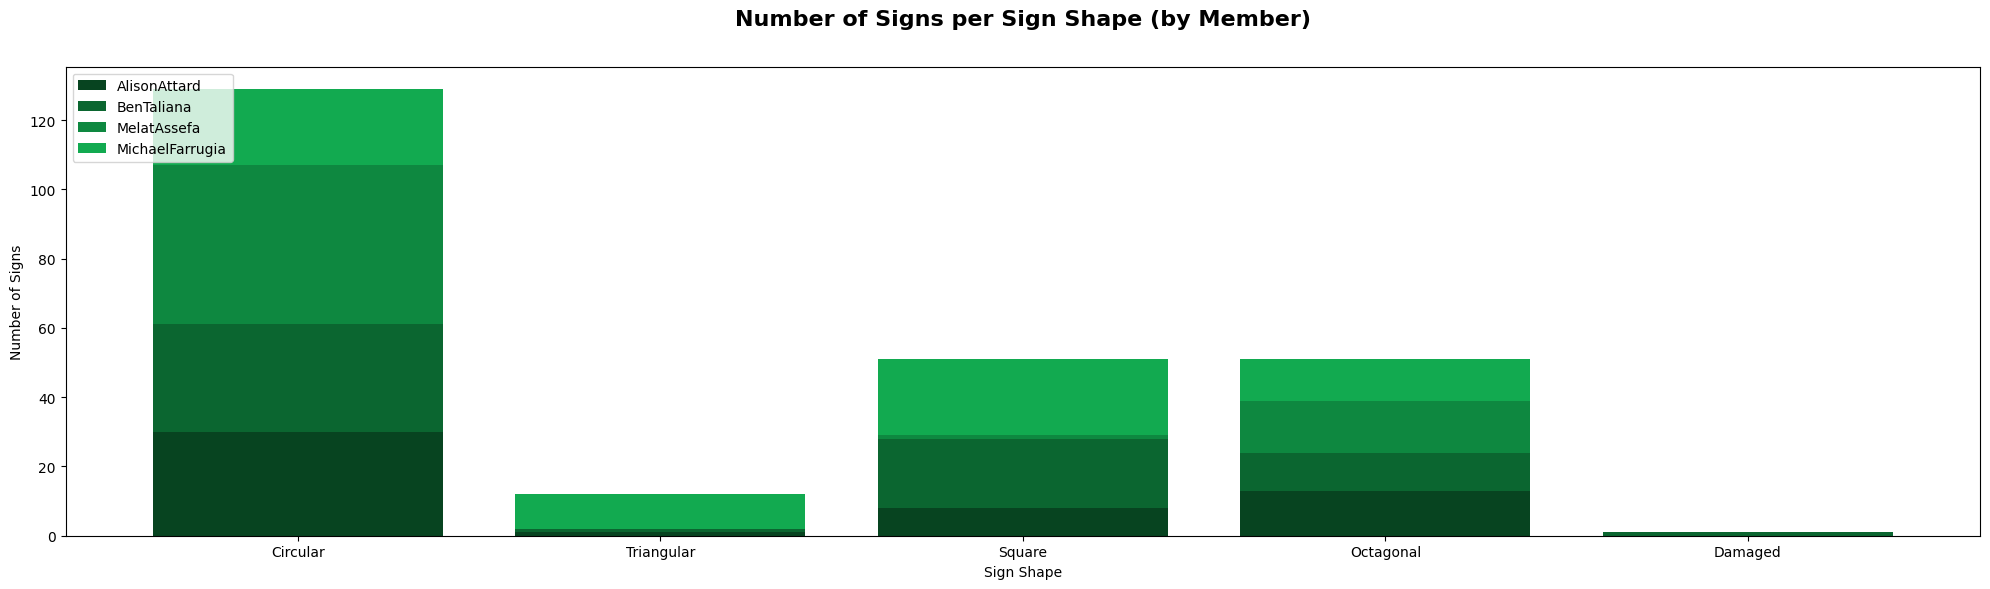

In [58]:
sign_shapes = ["Circular", "Triangular", "Square", "Octagonal", "Damaged"]

plt.figure(figsize = (20, 6))
bottom = np.zeros(len(sign_shapes))

for i, person in enumerate(sign_shape_statistics.keys()):
    counts = [sign_shape_statistics [person] [sign_shape] for sign_shape in sign_shapes]

    step_darkness = 1.0 + (i * 0.5)
    current_colour = adjust_lightness("#074420", step_darkness)

    plt.bar(sign_shapes, counts, bottom = bottom, label = person, color = current_colour)

    bottom = np.add(bottom, counts)

plt.xlabel("Sign Shape")
plt.ylabel("Number of Signs")
plt.title("Number of Signs per Sign Shape (by Member)", fontsize = 16, fontweight = "bold", pad = 30)
plt.legend(loc = "upper left")
plt.tight_layout()
plt.show()

## **Dataset Visualisation on a Map**

In [59]:
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS

num_images_per_member = {member: len([img for img in all_images_paths if img.startswith(os.path.join(member, "images")) and img.endswith("_Front.jpg")]) for member in group_5_members}
total_images = len([img for img in all_images_paths if img.endswith("_Front.jpg")])

def get_gps_tags(image_path):
    image = Image.open(image_path)
    exif_data = image._getexif()

    for tag, value in exif_data.items():
        tag_name = TAGS.get(tag, tag)

        if tag_name == "GPSInfo":
            gps_data = {}

            for gps_tag in value:
                gps_tag_name = GPSTAGS.get(gps_tag, gps_tag)
                gps_data [gps_tag_name] = value [gps_tag]

            return gps_data

In [60]:
def convert_dms_to_decimal(dms_coordinate):
    deg, minute, sec = dms_coordinate

    deg = float(deg)
    minute = float(minute) / 60
    sec = float(sec) / 3600
    
    return deg + minute + sec

In [61]:
def read_img_and_get_coords(image_path):
    img_gps = get_gps_tags(image_path)
    img_latitude = img_gps ["GPSLatitude"]
    img_longitude = img_gps ["GPSLongitude"]
    
    return (convert_dms_to_decimal(img_latitude), convert_dms_to_decimal(img_longitude))

In [62]:
def get_time_tags(image_path):
    image = Image.open(image_path)
    exif_data = image._getexif()

    for tag, value in exif_data.items():
        tag_name = TAGS.get(tag, tag)

        if tag_name == "DateTimeOriginal":
            return value

In [63]:
from datetime import datetime

def format_date(date_string):
    dt = datetime.strptime(str(date_string), "%Y:%m:%d %H:%M:%S")
    return dt.strftime("%d/%m/%Y %H:%M")

In [64]:
def read_img_and_get_datetime(image_path):
    img_time = get_time_tags(image_path)

    return format_date(img_time)

In [65]:
from folium import Map

first_img_coords = read_img_and_get_coords(all_images_paths [0])

map = Map(location = first_img_coords, zoom_start = 12)

In [66]:
def get_sign_type(img_name: str):
    json_entry = next((entry for entry in all_images_json if entry ["file_upload"].endswith(img_name)), None)

    return json_entry ["annotations"] [0] ["result"] [0] ["value"] ["rectanglelabels"] [0]

In [67]:
SIGN_COLOR_MAP = {
    "Stop": "red",
    "No Entry (One Way)": "purple",
    "Pedestrian Crossing": "blue",
    "Roundabout Ahead": "green",
    "No Through Road (T-Sign)": "beige",
    "Blind-Spot Mirror (Convex)": "orange"
}

In [68]:
from folium import Marker, Icon
from re import sub

for img_path in all_images_paths:
    img_name = img_path.split("images\\") [1].split(".") [0]

    # no need to plot all angles of the same sign
    if not img_name.endswith("Front"):
        continue
    
    img_coords = read_img_and_get_coords(img_path)

    img_id = img_name.split("_Front") [0].split("_") [1]

    member_name = img_name.split("_") [0].split("-") [1]

    try:
        img_datetime = read_img_and_get_datetime(img_path)
    except Exception as e:
        img_datetime = "Unknown"
    
    full_img_name = img_path.split("images\\") [1]
    sign_type = get_sign_type(full_img_name)

    icon_color = SIGN_COLOR_MAP.get(sign_type, "gray")

    Marker(
        location = [img_coords [0], img_coords [1]], 
        popup = f"{sub(r'(?<!^)(?=[A-Z])', ' ', member_name)}'s sign {img_id} taken at {img_datetime} ({sign_type})",
        icon = Icon(color = icon_color)
    ).add_to(map)

Note that on the map below, not all signs will appear due to the slight misprecision in GPS coordinates - some GPS coordinates did not capture the "seconds" and thus appear to be overlapping on the map.

In [69]:
map

## **Important Aspects of the Dataset**

When collecting the images for the dataset, we discovered a few important aspects about Maltese road signs that are worth noting, as they could impact the performance of any object detection model trained on the dataset:

1. There are **two types of pedestrian crossing signs** used in Malta: the Italian pedestrian crossing sign (with five vertical lines, also used outside of Italy) and the UK pedestrian crossing sign (with two horizontal dashed lines). Both signs are used interchangeably in Malta, which could lead to confusion for an object detection model if it is not trained on both types of signs. Our dataset includes both types of pedestrian crossing signs.

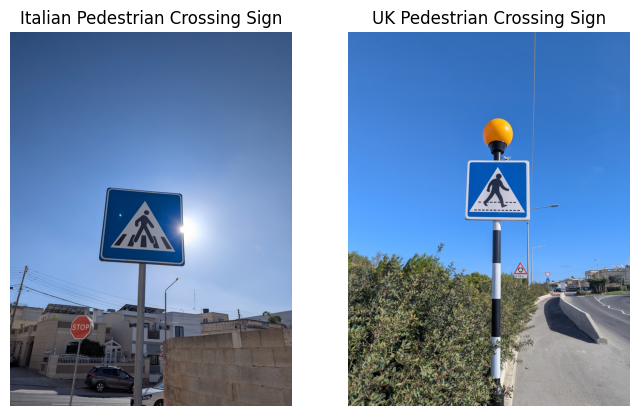

In [70]:
italian_pedestrian_crossing_sign = Image.open(os.path.join("MichaelFarrugia", "images", "e514429b-MichaelFarrugia_64_Front.jpg"))
uk_pedestrian_crossing_sign = Image.open(os.path.join("MichaelFarrugia", "images", "5abaa5dd-MichaelFarrugia_16_Front.jpg"))

plt.figure(figsize = (8, 5))

plt.subplot(1, 2, 1)
plt.imshow(italian_pedestrian_crossing_sign)
plt.title("Italian Pedestrian Crossing Sign", fontsize = 12)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(uk_pedestrian_crossing_sign)
plt.title("UK Pedestrian Crossing Sign", fontsize = 12)
plt.axis("off")

plt.show()

2. There are **two types of stop signs** used in Malta. One stop sign has a notably larger font size for the word "STOP", and the characters seem slightly taller compared to the other stop sign. Again, both signs are used interchangeably in Malta, so it is important for an object detection model to be trained on both types of stop signs. Our dataset includes both types of stop signs.

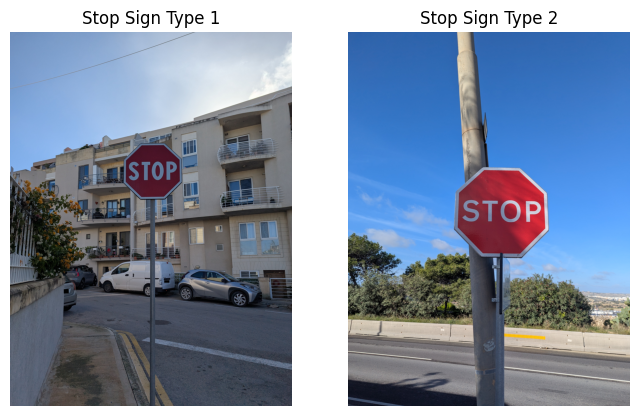

In [71]:
stop_sign_type_1 = Image.open(os.path.join("MichaelFarrugia", "images", "084c5849-MichaelFarrugia_1_Front.jpg"))
stop_sign_type_2 = Image.open(os.path.join("MichaelFarrugia", "images", "613de0fa-MichaelFarrugia_19_Front.jpg"))

plt.figure(figsize = (8, 5))

plt.subplot(1, 2, 1)
plt.imshow(stop_sign_type_1)
plt.title("Stop Sign Type 1", fontsize = 12)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(stop_sign_type_2)
plt.title("Stop Sign Type 2", fontsize = 12)
plt.axis("off")

plt.show()

** if you guys find anything else in your images that are worth pointing it out pls put it here **